In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

# Override the default linewidth and markersize
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [142]:
# Load the total energy demand data for NSW
total_demand_path = ('/content/totaldemand_nsw.csv')
total_demand_df = pd.read_csv(total_demand_path)

In [143]:
total_demand_df.head(10)
all_day_df = total_demand_df.copy()

In [112]:
total_demand_df = total_demand_df.set_index('DATETIME')
total_demand_df.index = pd.to_datetime(total_demand_df.index)

all_day_df = total_demand_df.copy()

#total_demand_df['DATETIME'] = pd.to_datetime(total_demand_df['DATETIME'], format='%Y-%m-%dT%H:%M:%SZ')

In [113]:
total_demand_df.describe()

,TOTALDEMAND
count,1.323398e+06
mean,8.067966e+03
std,1.308206e+03
min,4.286190e+03
25%,7.097480e+03
50%,7.996510e+03
75%,8.914310e+03
max,1.464883e+04


<ipython-input-114-c3900ca06726>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(total_demand_df["TOTALDEMAND"]).set_title("Total Demand Distribution")


Text(0.5, 1.0, 'Total Demand Distribution')

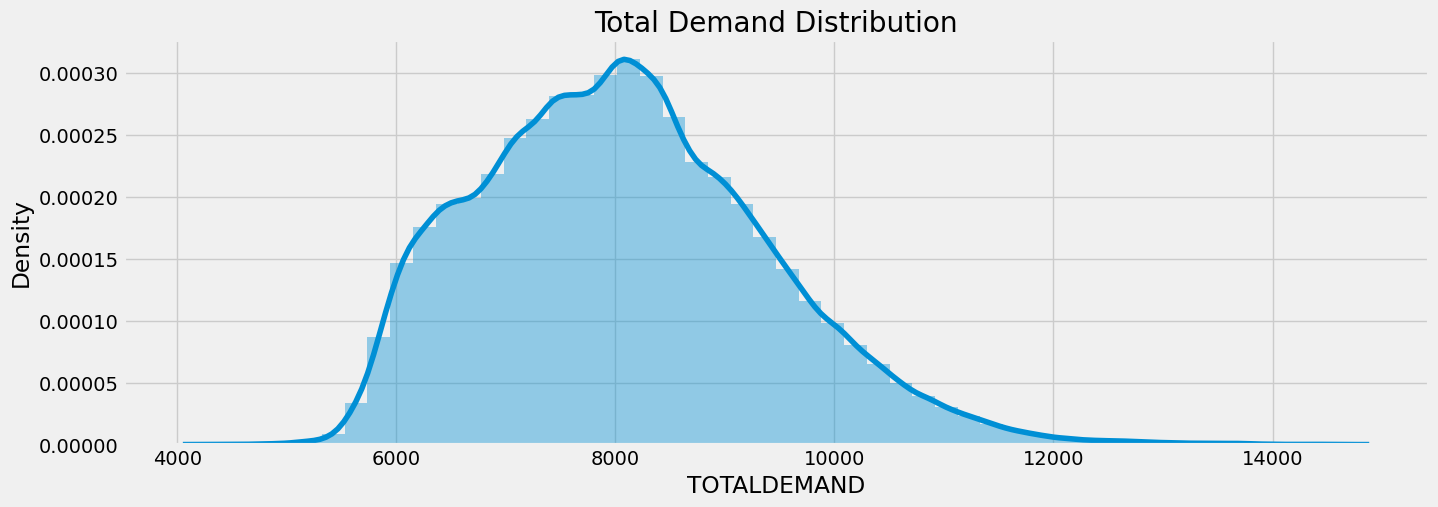

In [114]:
fig = plt.subplots(figsize=(15, 5))
sns.distplot(total_demand_df["TOTALDEMAND"]).set_title("Total Demand Distribution")

In [115]:
# Create a copy of the original DataFrame and add 'Year' column
year_df = total_demand_df.copy()
year_df['Year'] = year_df.index.year

# Create a copy of the original DataFrame and add 'Month' column
month_df = total_demand_df.copy()
month_df['Month'] = month_df.index.month

# Create a copy of the original DataFrame and add 'Day' column
day_df = total_demand_df.copy()
day_df['Day'] = day_df.index.day


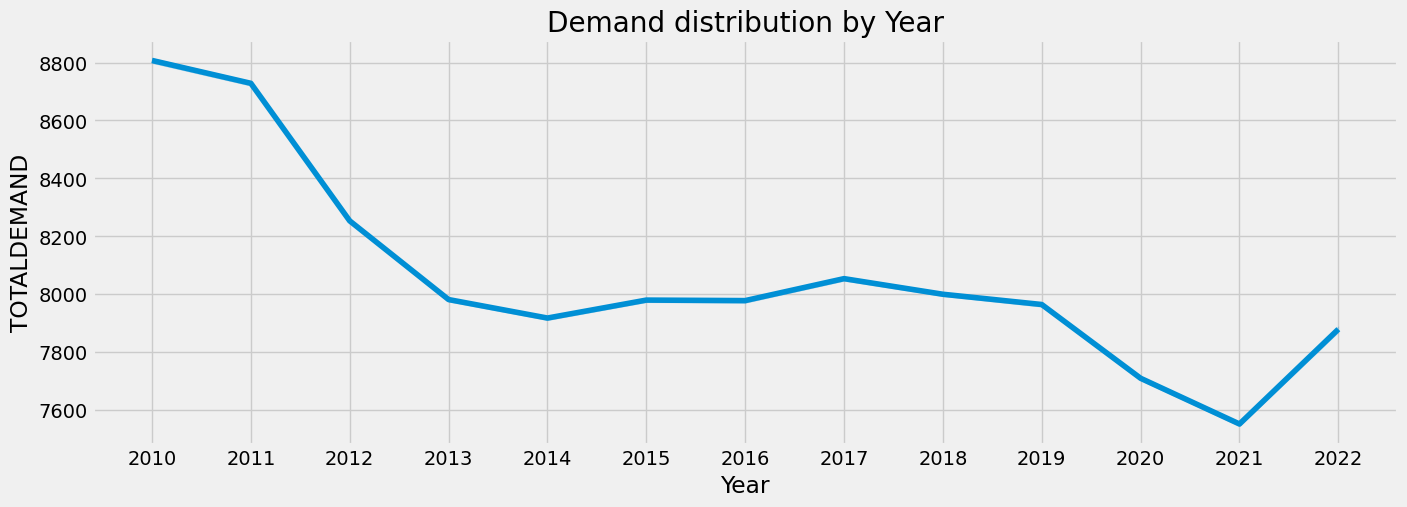

In [117]:

# Plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='Year', y='TOTALDEMAND', data=year_df).set_title('Demand distribution by Year')

# Get unique years and set them as xticks
unique_years = year_df['Year'].unique()
plt.xticks(unique_years)

plt.show()

In [ ]:
total_demand_df['DATETIME'] = pd.to_datetime(total_demand_df['DATETIME'])
total_demand_df.set_index('DATETIME', inplace=True)
total_demand_df['Month'] = total_demand_df.index.month
total_demand_df['Year'] = total_demand_df.index.year


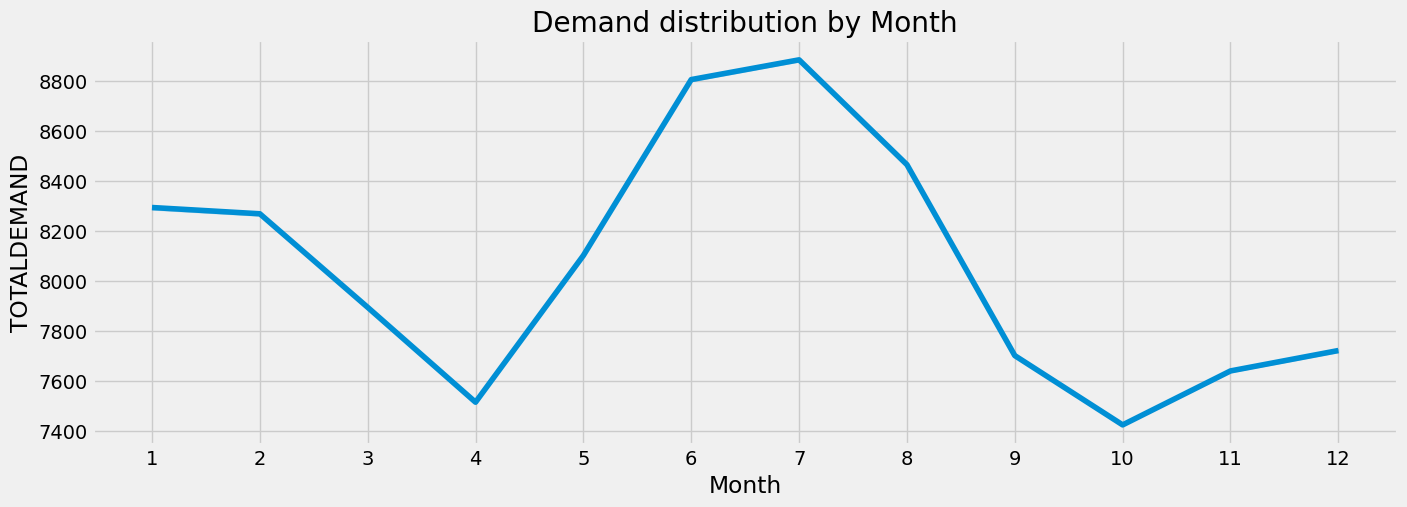

In [118]:
# Plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='Month', y='TOTALDEMAND', data=month_df).set_title('Demand distribution by Month')

# Set x-ticks to show all 12 unique months
plt.xticks(range(1, 13))  # 12 unique months from 1 to 12

plt.show()

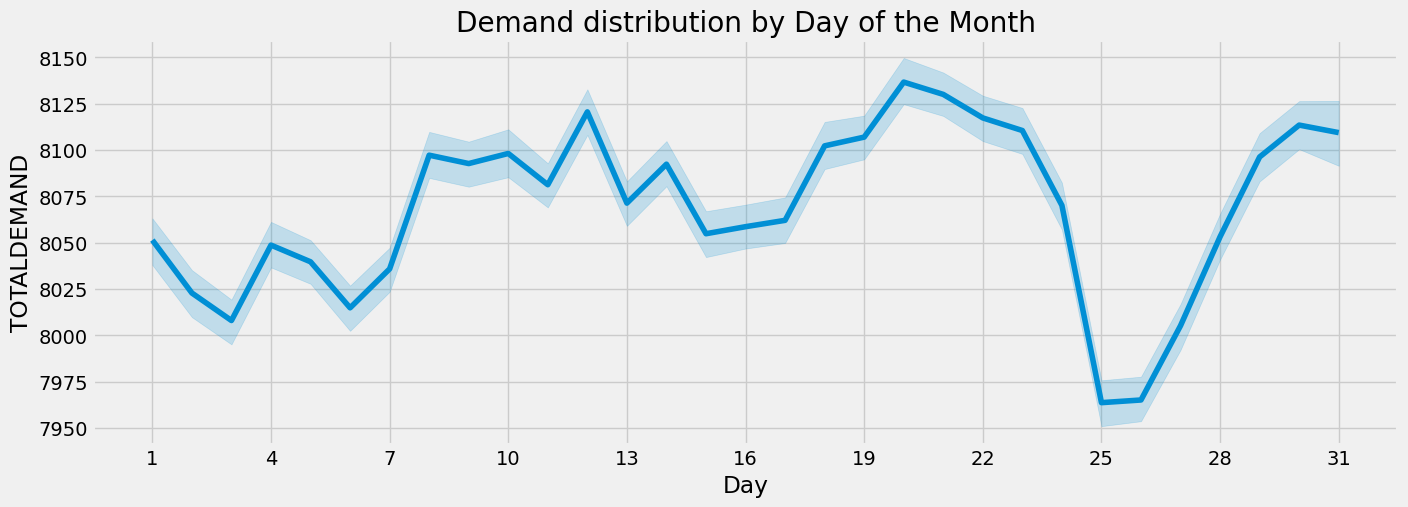

In [119]:
# Plot
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='Day', y='TOTALDEMAND', data=day_df).set_title('Demand distribution by Day of the Month')

# Set x-ticks to show days in increments of 3
plt.xticks(range(1, 32, 3))  # Days of the month from 1 to 31 in increments of 3

plt.show()

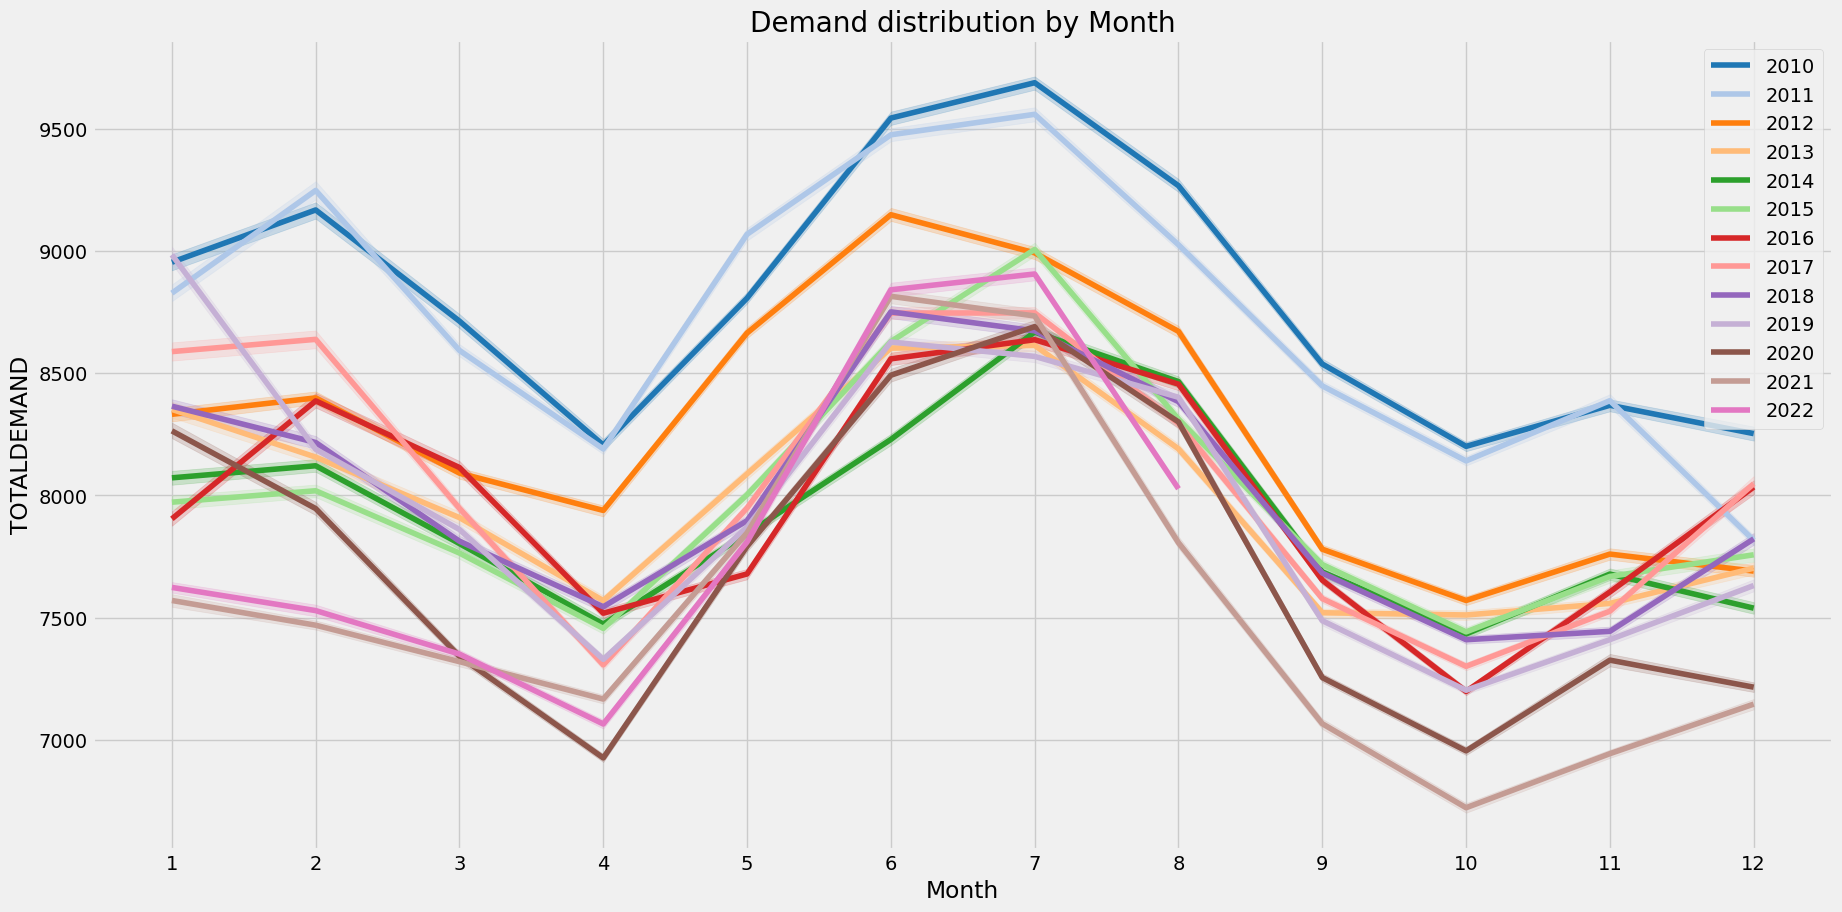

In [83]:
# Create a copy of the original DataFrame and add 'Year', 'Month', and 'Day' columns
new_df = total_demand_df.copy()
new_df['Year'] = total_demand_df.index.year
new_df['Month'] = total_demand_df.index.month
new_df['Day'] = total_demand_df.index.day

# Now, new_df contains the original data along with additional columns for Year, Month, and Day


# Plot
fig, ax = plt.subplots(figsize=(20, 10))  # Increase the size of the plot
sns.lineplot(x='Month', y='TOTALDEMAND', hue='Year', palette='tab20', data=new_df).set_title('Demand distribution by Month')

# Set x-ticks to show all 12 unique months
plt.xticks(range(1, 13))  # 12 unique months from 1 to 12

# Move the legend to the edge of the plot
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
# Convert 'DATETIME' to datetime format
#total_demand_df['DATETIME'] = pd.to_datetime(total_demand_df['DATETIME'])

In [120]:
total_demand_df.head(10)

,REGIONID,TOTALDEMAND
DATETIME,,
2010-01-01 00:00:00,NSW1,7997.41
2010-01-01 00:05:00,NSW1,7946.51
2010-01-01 00:10:00,NSW1,7921.55
2010-01-01 00:15:00,NSW1,7837.84
2010-01-01 00:20:00,NSW1,7781.11
2010-01-01 00:25:00,NSW1,7685.53
2010-01-01 00:30:00,NSW1,7683.34
2010-01-01 00:35:00,NSW1,7624.60
2010-01-01 00:40:00,NSW1,7606.74


In [121]:
missing_values_count = total_demand_df['TOTALDEMAND'].isna().sum()
print(f"Number of missing values in 'TOTALDEMAND': {missing_values_count}")


Number of missing values in 'TOTALDEMAND': 0


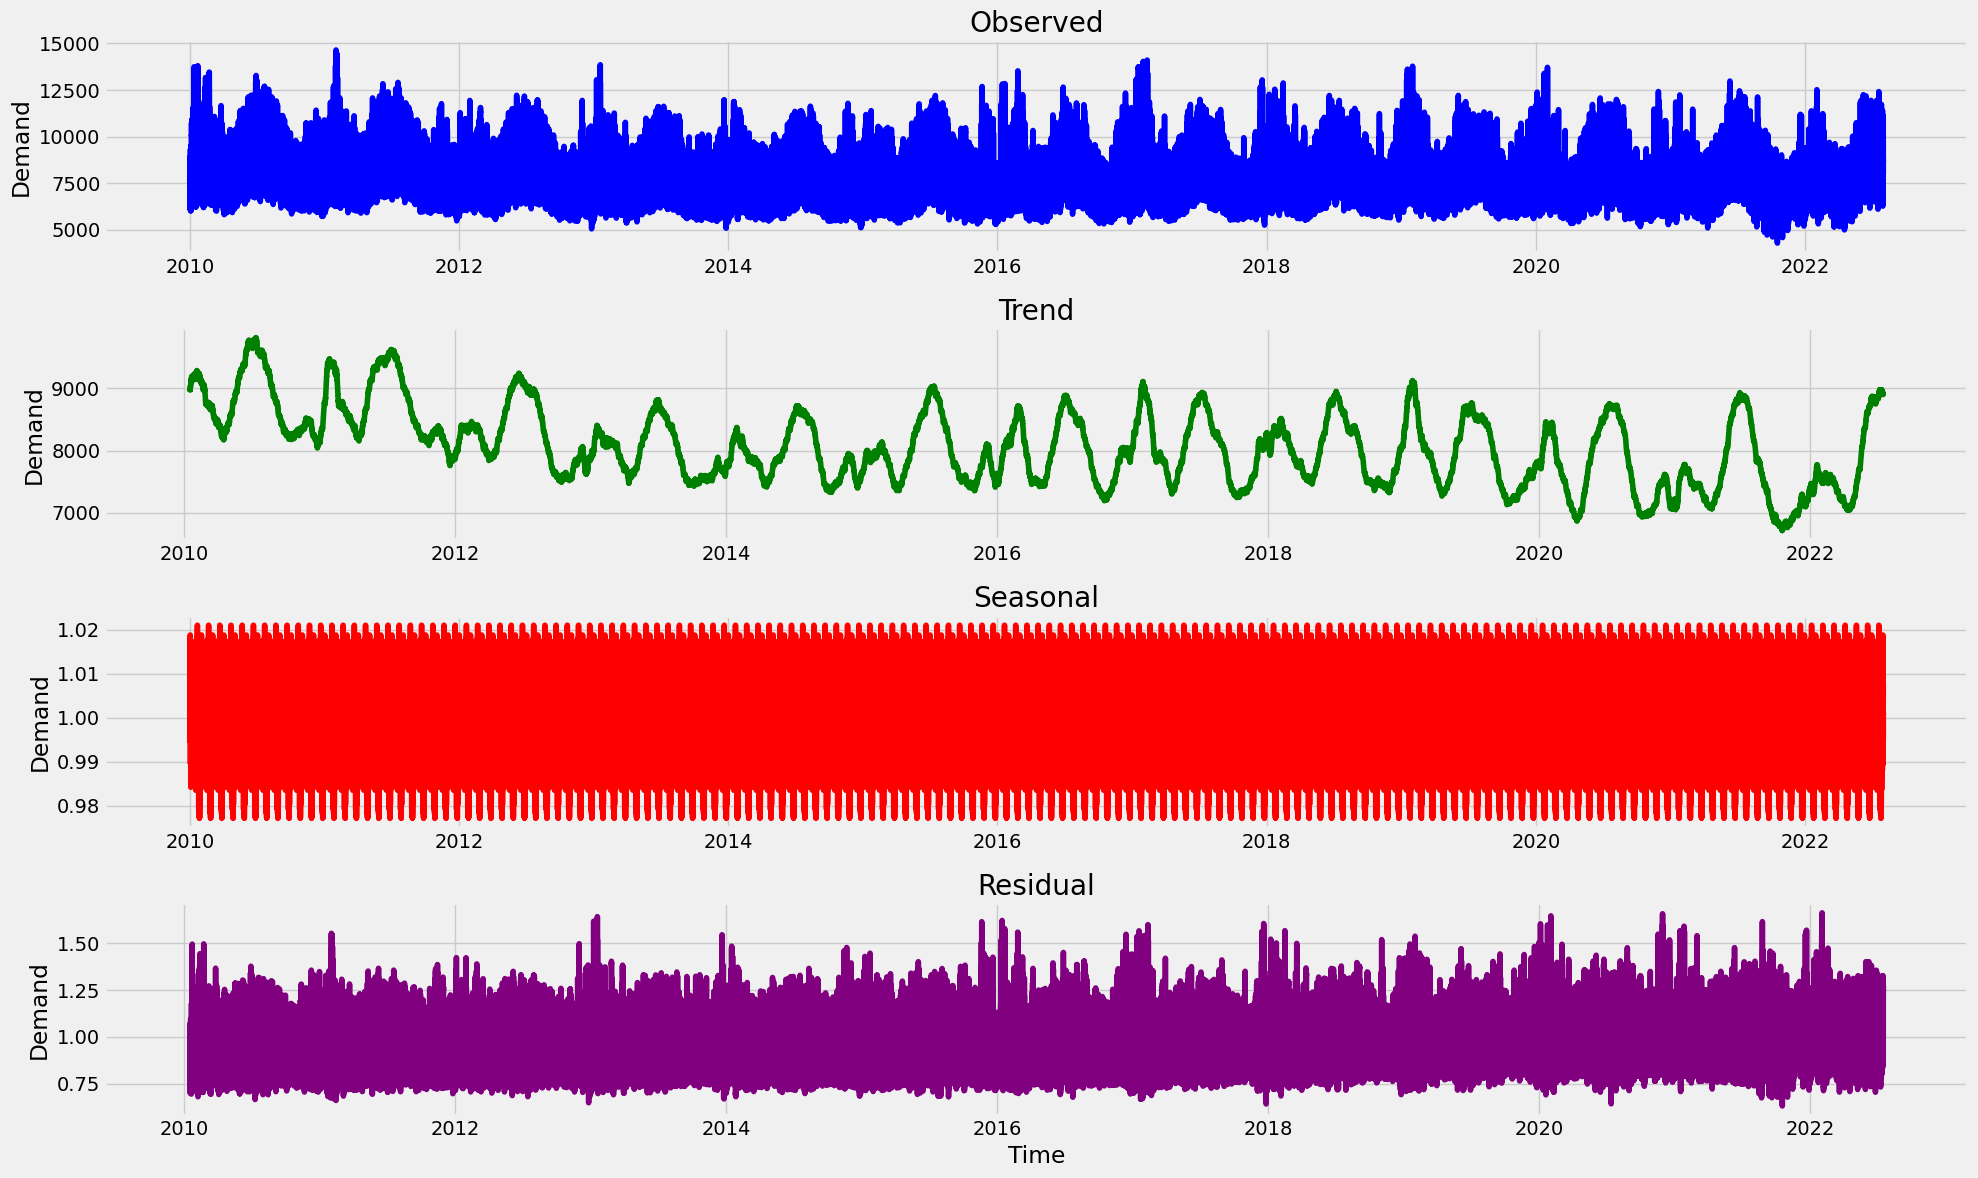

In [122]:
# Drop missing values or use any method you prefer to handle missing values
total_demand_df = total_demand_df.dropna()

# Perform seasonal decomposition
ANNUAL_PERIOD = 365 * 24
mult_decomp = seasonal_decompose(total_demand_df['TOTALDEMAND'], model='multiplicative', period=ANNUAL_PERIOD)

# Initialize the matplotlib figure with larger size
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

# Plot each component
axes[0].plot(mult_decomp.observed, color='blue')
axes[0].set_title('Observed')
axes[0].set_ylabel('Demand')

axes[1].plot(mult_decomp.trend, color='green')
axes[1].set_title('Trend')
axes[1].set_ylabel('Demand')

axes[2].plot(mult_decomp.seasonal, color='red')
axes[2].set_title('Seasonal')
axes[2].set_ylabel('Demand')

axes[3].plot(mult_decomp.resid, color='purple')
axes[3].set_title('Residual')
axes[3].set_ylabel('Demand')
axes[3].set_xlabel('Time')

# Show the plot
plt.tight_layout()
plt.show()

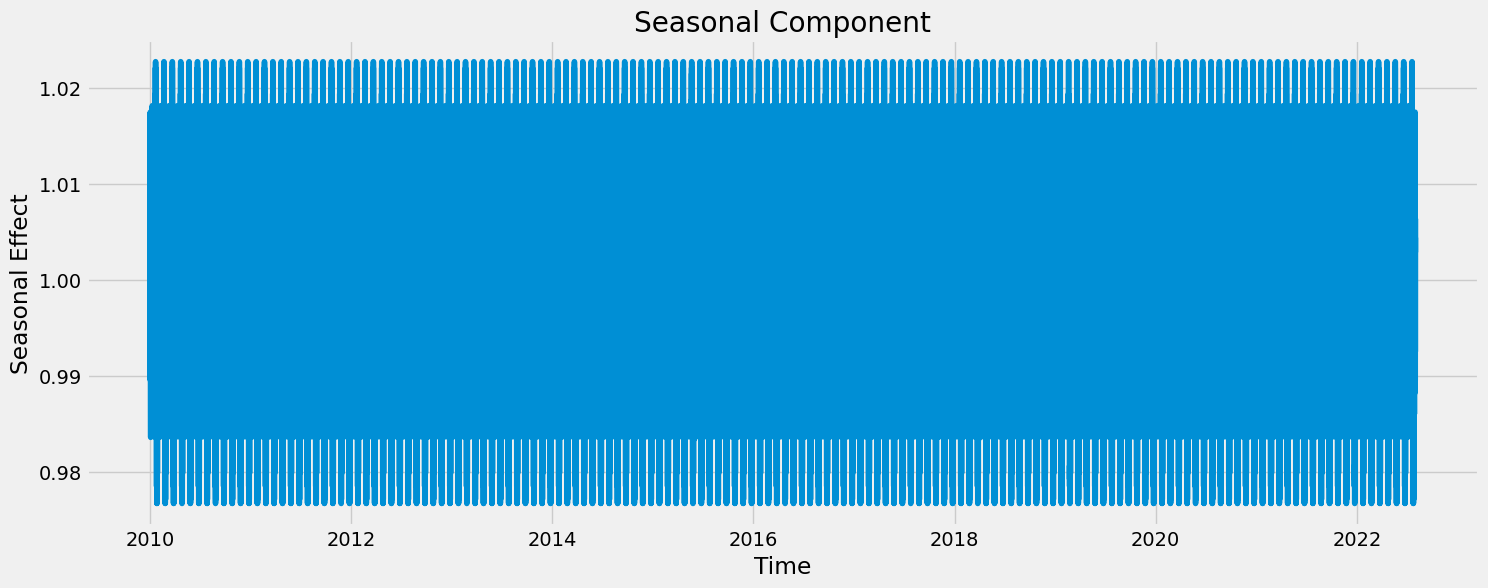

In [87]:
# Perform seasonal decomposition
ANNUAL_PERIOD = 365 * 24
mult_decomp = seasonal_decompose(total_demand_df['TOTALDEMAND'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)

# Plot only the seasonal component
plt.figure(figsize=(16, 6))
plt.title('Seasonal Component')
plt.plot(mult_decomp.seasonal)
plt.xlabel('Time')
plt.ylabel('Seasonal Effect')
plt.show()


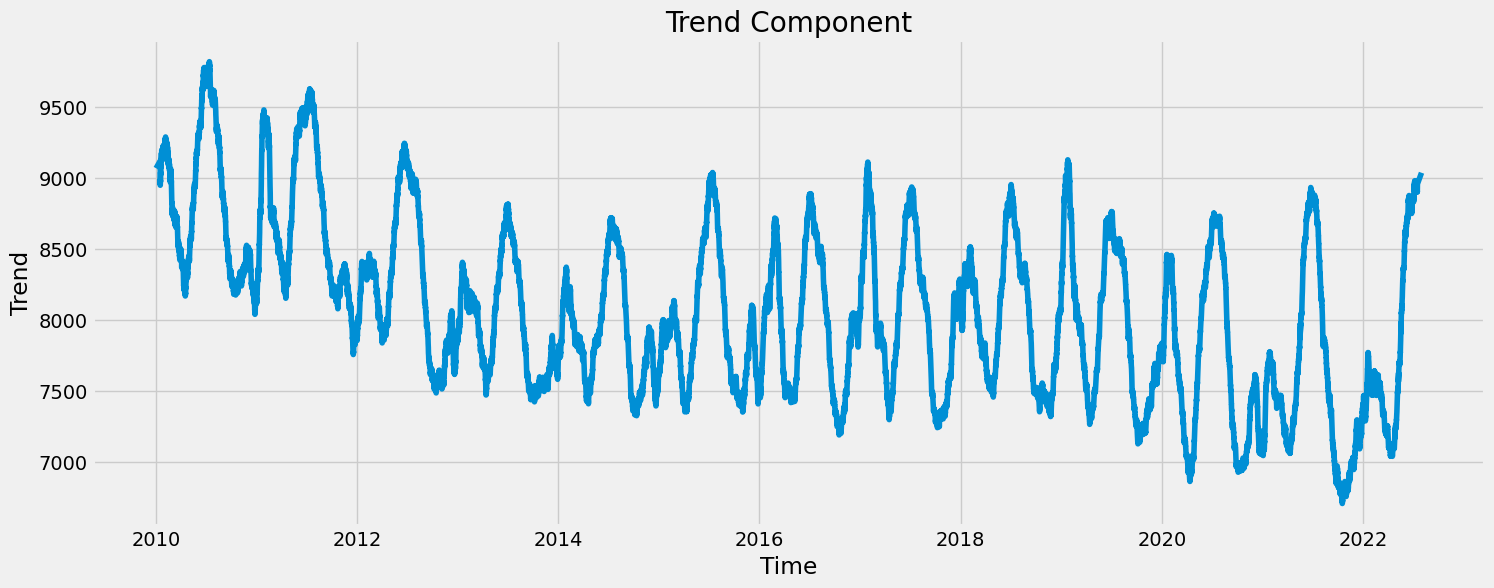

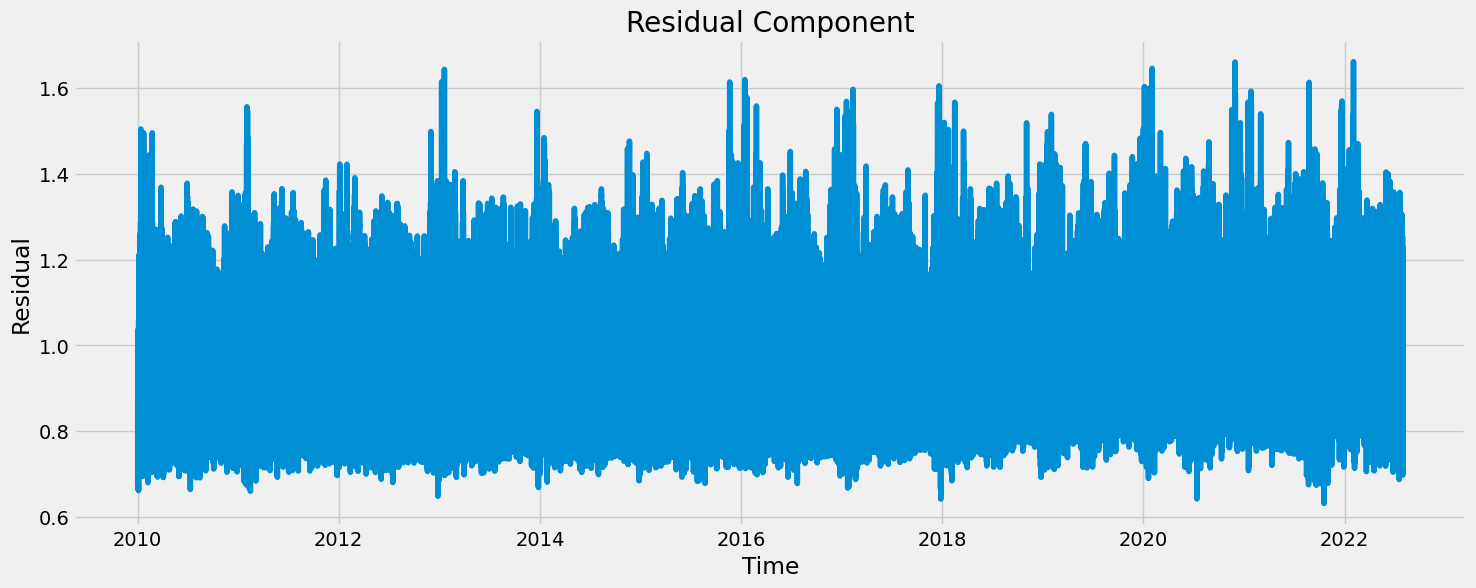

In [88]:
# Plot only the trend component
plt.figure(figsize=(16, 6))
plt.title('Trend Component')
plt.plot(mult_decomp.trend)
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()

# Plot only the residual component
plt.figure(figsize=(16, 6))
plt.title('Residual Component')
plt.plot(mult_decomp.resid)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()


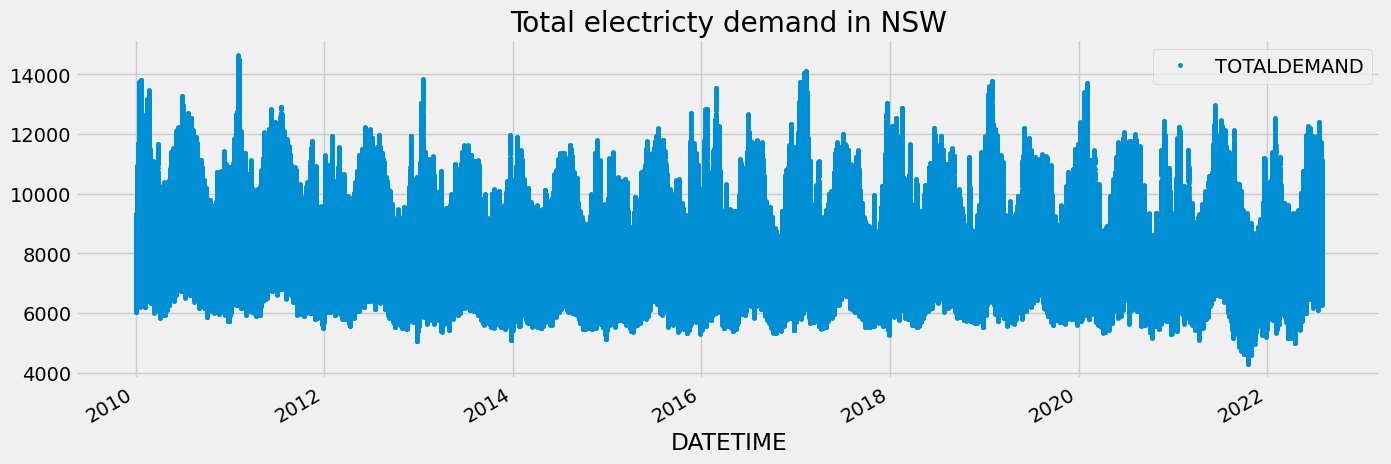

In [123]:
total_demand_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Total electricty demand in NSW')
plt.show()

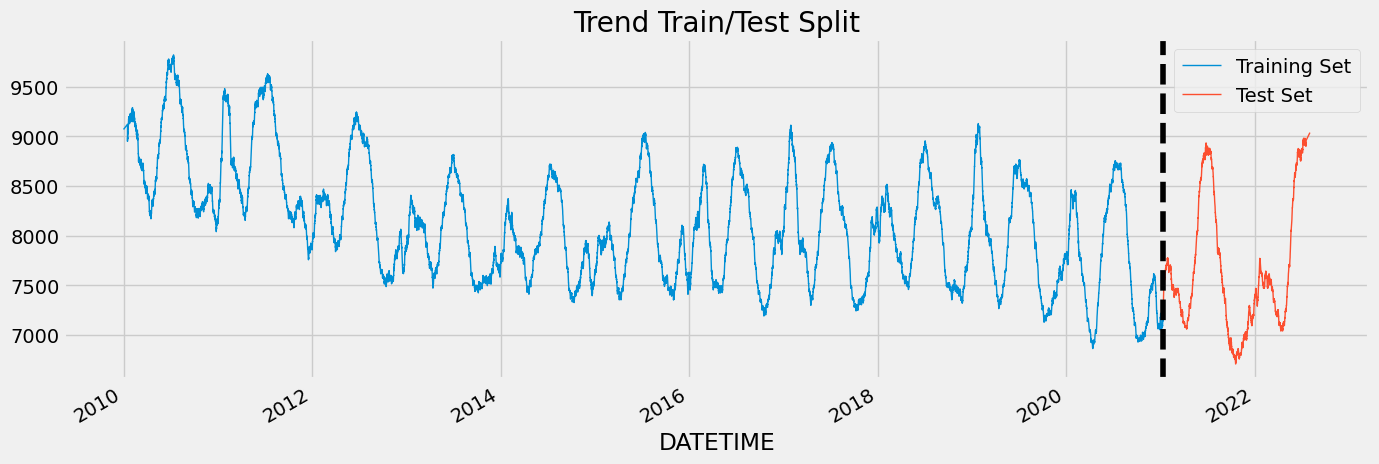

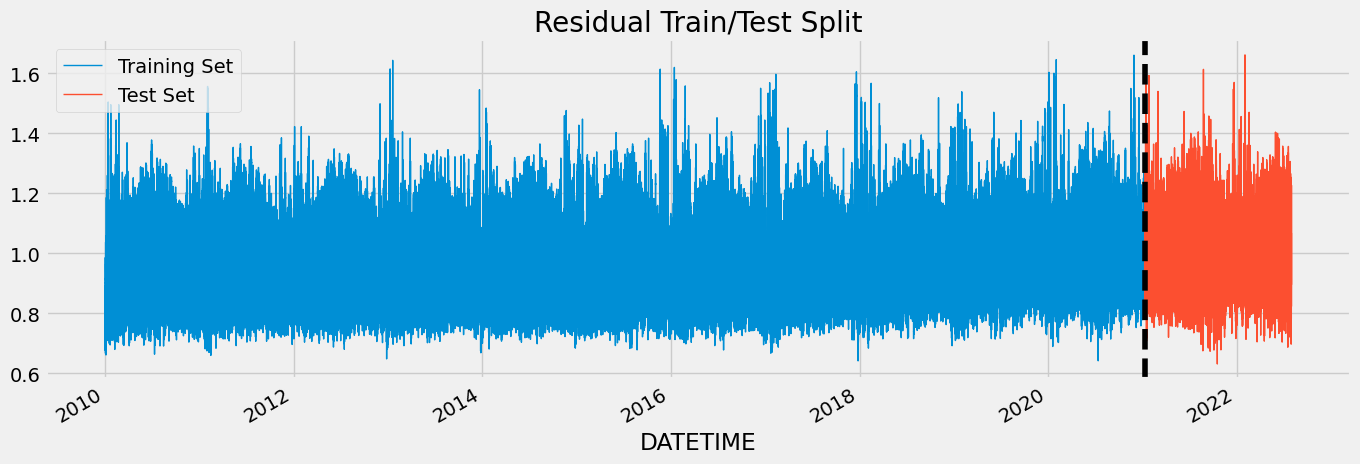

In [124]:
# Your existing seasonal decomposition code
ANNUAL_PERIOD = 365 * 24
mult_decomp = seasonal_decompose(total_demand_df['TOTALDEMAND'], model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)

# Extract the trend and residual components
trend = mult_decomp.trend.dropna()
resid = mult_decomp.resid.dropna()

# Define the function for plotting train/test split
def plot_train_test_split(df: pd.DataFrame, split_date: str) -> None:
    train = df.loc[df.index < pd.Timestamp(split_date)]
    test = df.loc[df.index >= pd.Timestamp(split_date)]

    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, label='Training Set', title=f'{df.name} Train/Test Split', linewidth=1)
    test.plot(ax=ax, label='Test Set', linewidth=1)
    ax.axvline(pd.Timestamp(split_date), color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()

# Define the cutoff date for train/test split
TARGET_TEST_CUTOFF_DATE =  '01-09-2021'  # Replace with your specific date

# Plot the train/test split for the trend component
trend.name = 'Trend'
plot_train_test_split(trend, TARGET_TEST_CUTOFF_DATE)

# Plot the train/test split for the residual component
resid.name = 'Residual'
plot_train_test_split(resid, TARGET_TEST_CUTOFF_DATE)


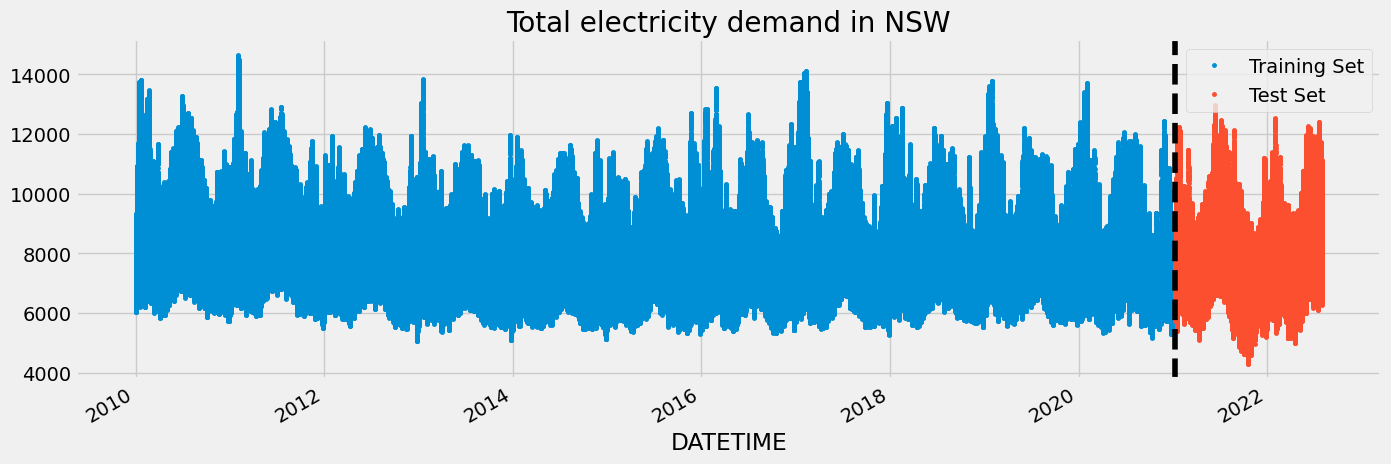

In [91]:
# Define the function for plotting train/test split
def plot_train_test_split(df: pd.DataFrame, split_date: str, title: str, marker_style: str) -> None:
    train = df.loc[df.index < pd.Timestamp(split_date)]
    test = df.loc[df.index >= pd.Timestamp(split_date)]

    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, label='Training Set', title=title, style=marker_style, linewidth=1)
    test.plot(ax=ax, label='Test Set', style=marker_style, linewidth=1)
    ax.axvline(pd.Timestamp(split_date), color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()


# Plot the train/test split for the total demand data
plot_train_test_split(total_demand_df['TOTALDEMAND'],
                      TARGET_TEST_CUTOFF_DATE,
                      title='Total electricity demand in NSW',
                      marker_style='.')


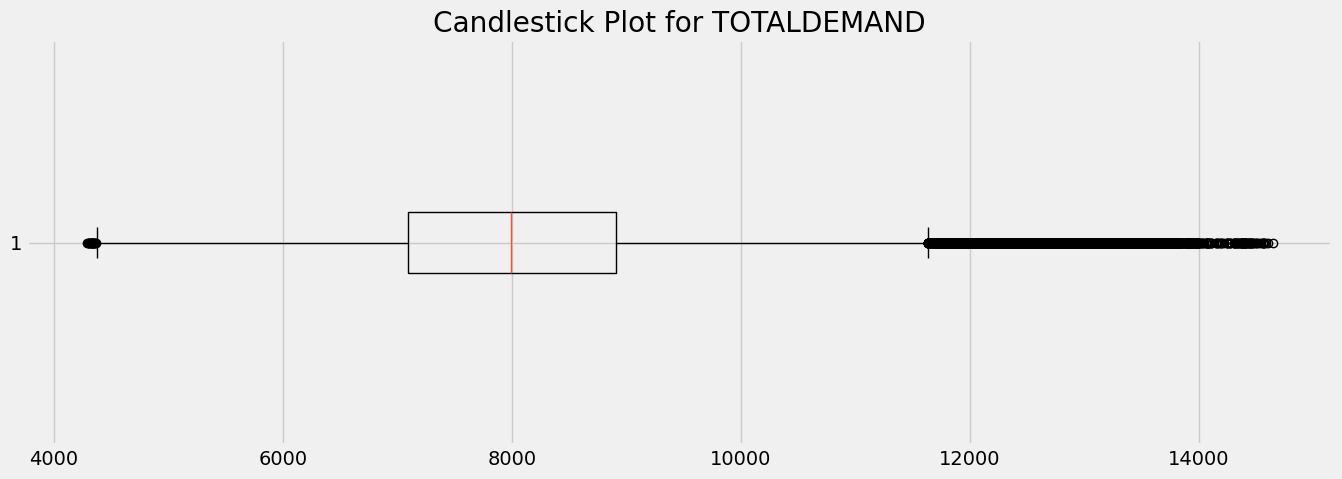

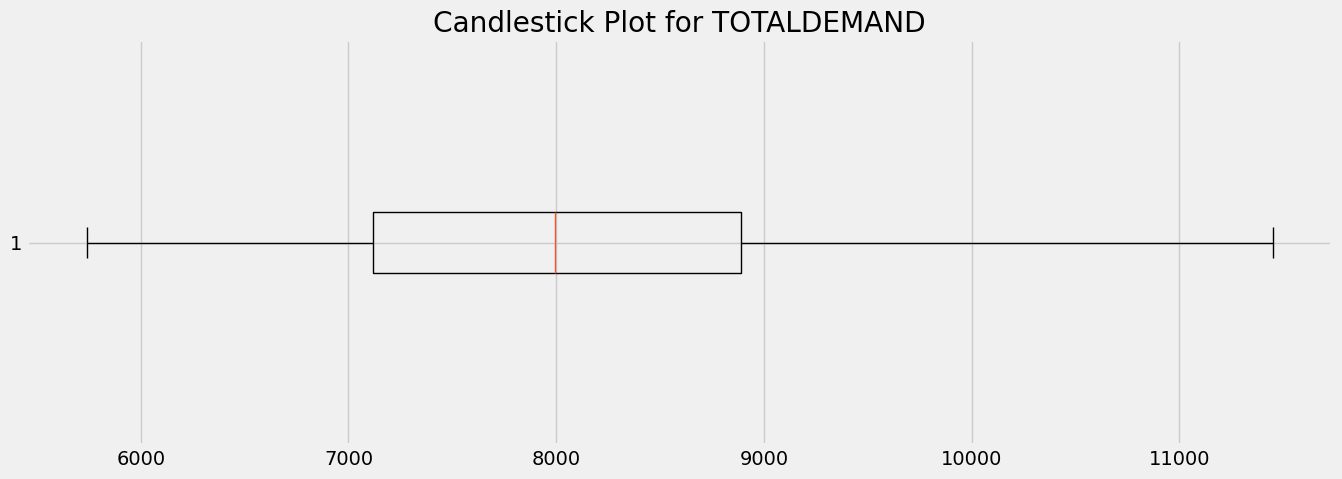

In [125]:


# Generate sample data (replace this with 'total_demand_df['TOTALDEMAND']' in your case)
# df = pd.DataFrame({'TOTALDEMAND': ...})

# Define function to plot candlestick for outliers
def plot_candlestick(df, column):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.boxplot(df[column], vert=False)
    ax.set_title(f'Candlestick Plot for {column}')
    plt.show()

# Plot the candlestick chart for the 'TOTALDEMAND' column
plot_candlestick(total_demand_df, 'TOTALDEMAND')

# Define function to remove outliers based on percentile
def remove_outliers_by_percentile(df, column, lower_percentile=1, upper_percentile=99):
    lower = df[column].quantile(lower_percentile / 100)
    upper = df[column].quantile(upper_percentile / 100)
    mask = (df[column] >= lower) & (df[column] <= upper)
    return df[mask]

# Remove outliers in 'TOTALDEMAND' based on the 1st and 99th percentile
filtered_df = remove_outliers_by_percentile(total_demand_df, 'TOTALDEMAND')

# Re-plot the candlestick chart for the filtered 'TOTALDEMAND' column
plot_candlestick(filtered_df, 'TOTALDEMAND')


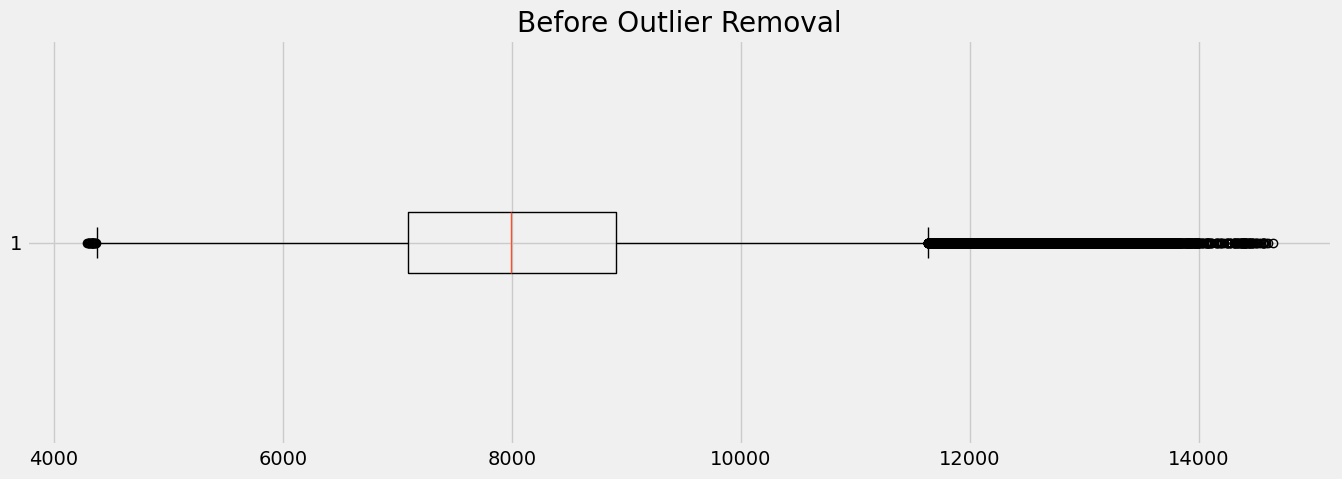

Number of items removed: 26468


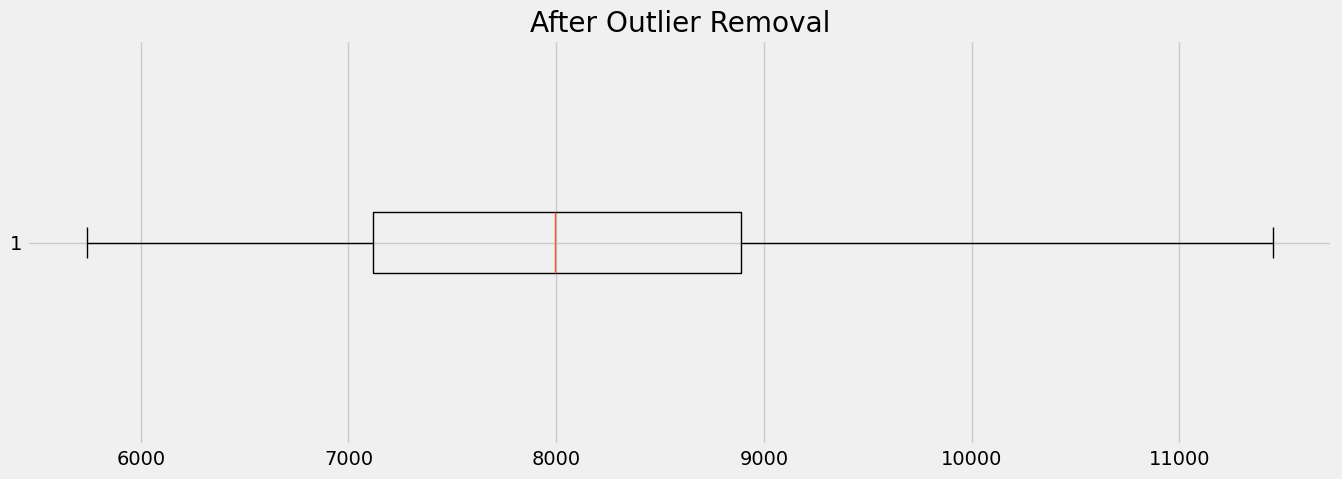

In [126]:
# Define function to plot candlestick for outliers
def plot_candlestick(df, column, title):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.boxplot(df[column], vert=False)
    ax.set_title(title)
    plt.show()

# Plot the candlestick chart for the 'TOTALDEMAND' column (Before removal)
plot_candlestick(total_demand_df, 'TOTALDEMAND', 'Before Outlier Removal')

# Define function to remove outliers based on percentile
def remove_outliers_by_percentile(df, column, lower_percentile=1, upper_percentile=99):
    lower = df[column].quantile(lower_percentile / 100)
    upper = df[column].quantile(upper_percentile / 100)
    mask = (df[column] >= lower) & (df[column] <= upper)

    removed_items = len(df) - sum(mask)

    return df[mask], removed_items

# Remove outliers in 'TOTALDEMAND' based on the 1st and 99th percentile
filtered_df, num_removed = remove_outliers_by_percentile(total_demand_df, 'TOTALDEMAND')

# Display the number of items removed
print(f"Number of items removed: {num_removed}")

# Re-plot the candlestick chart for the filtered 'TOTALDEMAND' column (After removal)
plot_candlestick(filtered_df, 'TOTALDEMAND', 'After Outlier Removal')


In [94]:
total_demand_df.describe()

,TOTALDEMAND
count,1.323398e+06
mean,8.067966e+03
std,1.308206e+03
min,4.286190e+03
25%,7.097480e+03
50%,7.996510e+03
75%,8.914310e+03
max,1.464883e+04


In [95]:
filtered_df.describe()

,TOTALDEMAND
count,1.296930e+06
mean,8.052467e+03
std,1.229659e+03
min,5.739310e+03
25%,7.117333e+03
50%,7.996510e+03
75%,8.891417e+03
max,1.144971e+04


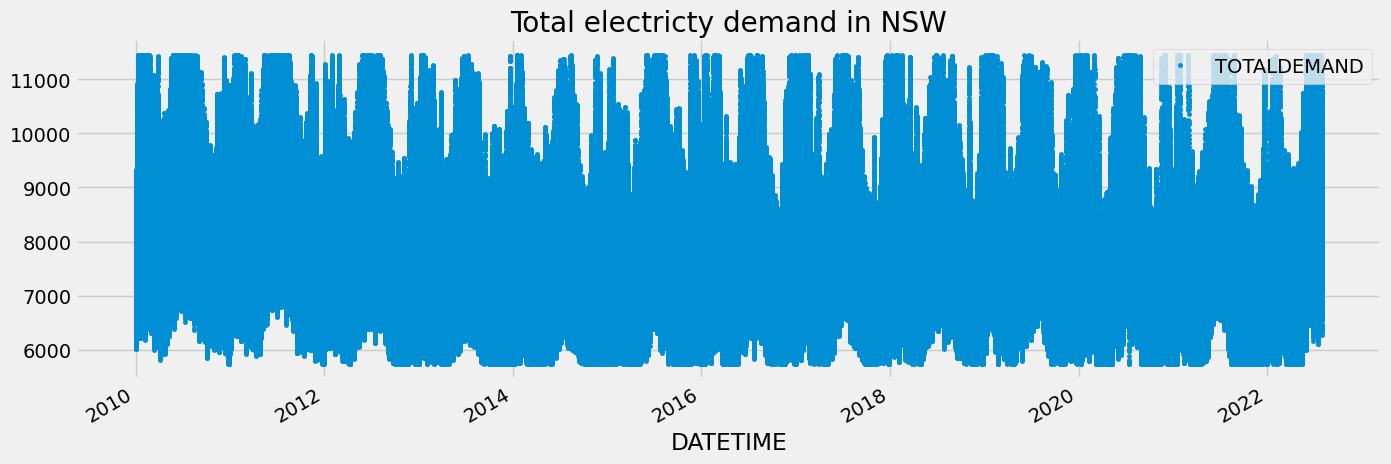

In [96]:
filtered_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Total electricty demand in NSW')
plt.show()

In [127]:
# Check the minimum and maximum date in the DataFrame
min_date, max_date = total_demand_df.index.min(), total_demand_df.index.max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")


Minimum Date: 2010-01-01 00:00:00
Maximum Date: 2022-08-01 00:00:00


In [128]:

import matplotlib.dates as mdates

def plot_week_of_data(df: pd.DataFrame, start_date: str, end_date: str) -> None:
    # Ensure the DataFrame index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index must be a DatetimeIndex.")
        return

    # Remove invalid dates
    df = df[df.index.notnull()]
    df = df.loc[(df.index.year >= 1) & (df.index.year <= 9999)]

    # Ensure the specified date range exists within the DataFrame
    min_date, max_date = df.index.min(), df.index.max()
    if pd.Timestamp(start_date) < min_date or pd.Timestamp(end_date) > max_date:
        print(f"Error: Specified date range ({start_date} to {end_date}) is outside DataFrame date range.")
        return

    # Filter data based on date range and plot
    week_data = df.loc[(df.index >= pd.Timestamp(start_date)) & (df.index <= pd.Timestamp(end_date))]

    if week_data.empty:
        print("Error: No data points found in the specified date range.")
        return

    fig, ax = plt.subplots(figsize=(15, 5))
    week_data.plot(ax=ax, title='Week Of Data', linewidth=1, markersize=5)

    # Format x-axis to show dates clearly
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.show()

# Replace this with your actual DataFrame and specify the date range
# Ensure that total_demand_df has a DatetimeIndex
# total_demand_df.index = pd.to_datetime(total_demand_df.index)

# Then plot the data
plot_week_of_data(total_demand_df, '2018-01-01', '2018-01-08')


ValueError: ignored

Error in callback <function _draw_all_if_interactive at 0x7e42b7d49750> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1500x500 with 1 Axes>

In [129]:

pop_nsw_path = ('/content/NSW estimated population.xlsx')
pop_nsw_df = pd.read_excel(pop_nsw_path)
pop_nsw_df

,Date,Estimated Resident Population
0,1981-06-01,5234889
1,1981-09-01,5249455
2,1981-12-01,5266894
3,1982-03-01,5286119
4,1982-06-01,5303580
...,...,...
163,2022-03-01,8137688
164,2022-06-01,8166525
165,2022-09-01,8206865
166,2022-12-01,8243268


In [ ]:
pop_nsw_df

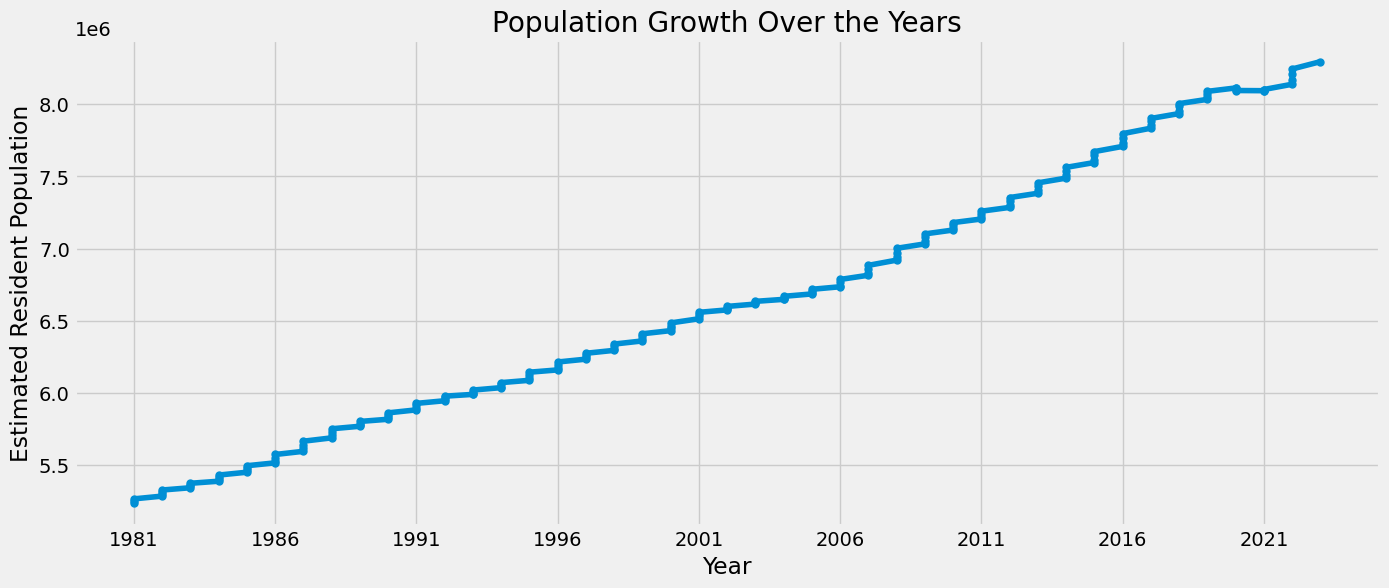

In [102]:
# Set 'Date' as index and convert it to datetime format
pop_nsw_df = pop_nsw_df.set_index('Date')
pop_nsw_df.index = pd.to_datetime(pop_nsw_df.index)

# Extract the year and add it as a new column
pop_nsw_df['Year'] = pop_nsw_df.index.year

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(pop_nsw_df['Year'], pop_nsw_df['Estimated Resident Population'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Estimated Resident Population')
plt.title('Population Growth Over the Years')
plt.grid(True)

# Customize x-axis to show every 5 years
start_year = pop_nsw_df['Year'].min()
end_year = pop_nsw_df['Year'].max()
plt.xticks(range(start_year, end_year+1, 5))

plt.show()

In [104]:
temperature_path = ('/content/temperature_nsw.csv')
temperature_df = pd.read_csv(temperature_path)
temperature_df

,DATETIME,LOCATION,TEMPERATURE
0,2010-01-01 00:00:00,94766.0,23.1
1,2010-01-01 00:01:00,94766.0,23.1
2,2010-01-01 00:30:00,94766.0,22.9
3,2010-01-01 00:50:00,94766.0,22.7
4,2010-01-01 01:00:00,94766.0,22.6
...,...,...,...
247641,2022-07-31 22:00:00,94766.0,14.0
247642,2022-07-31 22:30:00,94766.0,13.2
247643,2022-07-31 23:00:00,94766.0,13.3
247644,2022-07-31 23:30:00,94766.0,12.7


KeyError: ignored

In [151]:
#temperature_df = pd.DataFrame(temperature_data)
#total_demand_df = pd.DataFrame(total_demand_data)

# Convert 'DATETIME' to datetime format
temperature_df['DATETIME'] = pd.to_datetime(temperature_df['DATETIME'])
all_day_df['DATETIME'] = pd.to_datetime(all_day_df['DATETIME'])

# Create a 'DAY' column to represent just the date part of 'DATETIME'
temperature_df['DAY'] = temperature_df['DATETIME'].dt.date
all_day_df['DAY'] = all_day_df['DATETIME'].dt.date

# Calculate the daily average temperature and total demand
avg_temperature_per_day = temperature_df.groupby('DAY')['TEMPERATURE'].mean().reset_index().round(1)
avg_total_demand_per_day = all_day_df.groupby('DAY')['TOTALDEMAND'].mean().reset_index().round(1)

# Merge the daily averages based on 'DAY'
merged_df = pd.merge(avg_temperature_per_day, avg_total_demand_per_day, on='DAY')
merged_df


,DAY,TEMPERATURE,TOTALDEMAND
0,2010-01-01,25.1,7793.5
1,2010-01-02,24.8,8012.3
2,2010-01-03,19.4,7393.4
3,2010-01-04,20.6,8254.5
4,2010-01-05,22.7,8832.0
...,...,...,...
4588,2022-07-28,12.4,8712.7
4589,2022-07-29,11.5,8850.6
4590,2022-07-30,8.6,8601.1
4591,2022-07-31,9.8,8699.9


In [155]:
clean_merged_df = merged_df[merged_df['TEMPERATURE'] != -9999.0]

clean_merged_df

,DAY,TEMPERATURE,TOTALDEMAND
0,2010-01-01,25.1,7793.5
1,2010-01-02,24.8,8012.3
2,2010-01-03,19.4,7393.4
3,2010-01-04,20.6,8254.5
4,2010-01-05,22.7,8832.0
...,...,...,...
4588,2022-07-28,12.4,8712.7
4589,2022-07-29,11.5,8850.6
4590,2022-07-30,8.6,8601.1
4591,2022-07-31,9.8,8699.9


In [153]:
# Identify rows where the temperature is below -10
low_temperature_rows = temperature_df[temperature_df['TEMPERATURE'] < -10]
low_temperature_rows

,DATETIME,LOCATION,TEMPERATURE,DAY
4234,2010-03-23 15:00:00,94766.0,-9999.0,2010-03-23
6017,2010-04-27 10:00:00,94766.0,-9999.0,2010-04-27
6196,2010-05-01 06:00:00,94766.0,-9999.0,2010-05-01
10611,2010-07-23 18:30:00,94766.0,-9999.0,2010-07-23
18423,2010-12-20 01:30:00,94766.0,-9999.0,2010-12-20
18424,2010-12-20 02:00:00,94766.0,-9999.0,2010-12-20
18425,2010-12-20 02:30:00,94766.0,-9999.0,2010-12-20
18426,2010-12-20 03:00:00,94766.0,-9999.0,2010-12-20
18427,2010-12-20 03:30:00,94766.0,-9999.0,2010-12-20
18428,2010-12-20 04:00:00,94766.0,-9999.0,2010-12-20


<module 'seaborn' from '/usr/local/lib/python3.10/dist-packages/seaborn/__init__.py'>

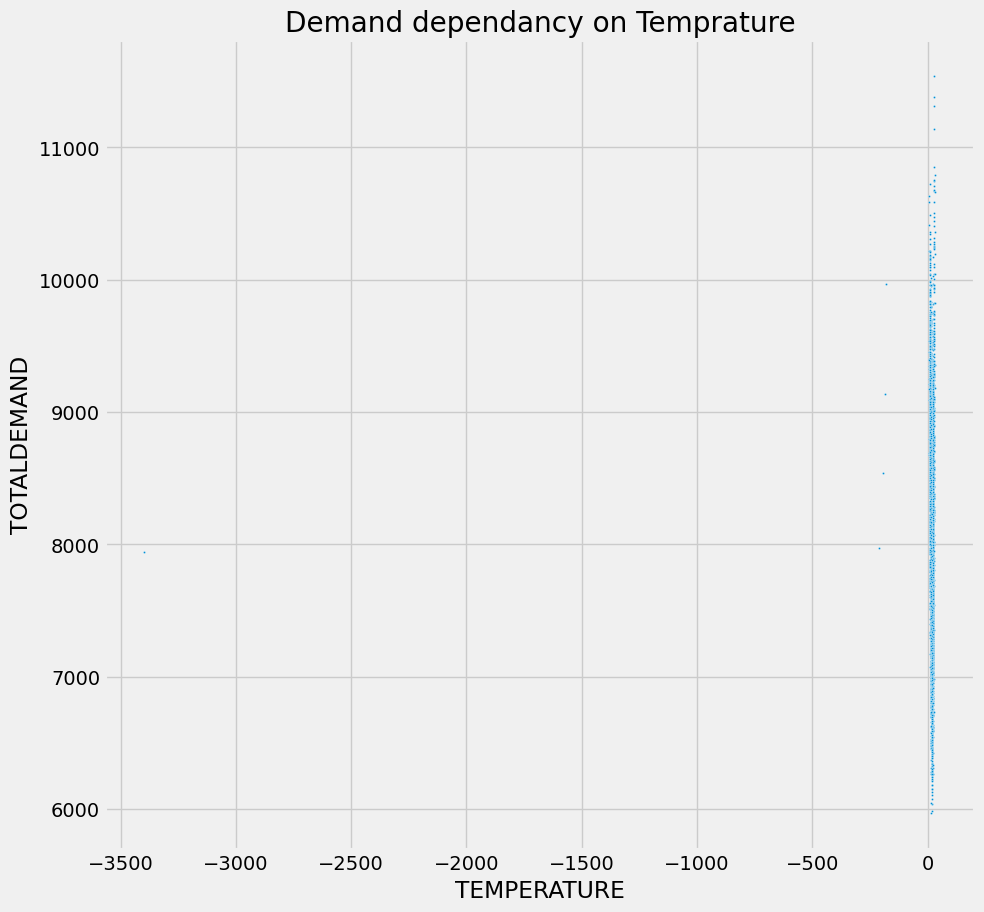

In [152]:
fig = plt.subplots(figsize=(10, 10))
sns.scatterplot (x=merged_df.TEMPERATURE, y=merged_df.TOTALDEMAND, data=merged_df,marker=".",s=10).set_title('Demand dependancy on Temprature')
sns